In [1]:
import numpy as np 
import pandas as pd 
import os 
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import skimage
from keras.preprocessing import image
from keras.applications import VGG16
from keras.models import Model
from keras import backend
import json
# from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

Using TensorFlow backend.


In [5]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import keras
import tensorflow as tf

In [6]:
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [7]:
def load_data(filename):
    data = pd.read_json('../input/train-10k-json/'+filename+'.json')
    image_id_list = data.columns
    caption_list = []
    
    for i in image_id_list:
        caption_list.append(data[i])
    
    print("Data Size - ", len(image_id_list), "\nCaptions Per Image - ", len(caption_list[0]))
    
    return image_id_list, caption_list

In [8]:
image_list_train, caption_list_train = load_data('new_train_10')

Data Size -  9562 
Captions Per Image -  5


In [ ]:
image_list_val, caption_list_val = load_data('val_data')

In [9]:
vgg16_model = VGG16(include_top = True, weights = 'imagenet')
vgg16_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 14s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__

In [11]:
dense_output = vgg16_model.get_layer('fc2')
dense_output

In [12]:
custom_vgg16 = Model(inputs = vgg16_model.input, outputs = dense_output.output)

In [13]:
def load_image(path, size = None):
    img = Image.open(path)
    
    if not size is None:
        img = image.img_to_array(img)
        img = skimage.transform.resize(img, size)
    img = np.array(img)
    img = img / 255.0
    
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    return img

In [14]:
def show_image(idx, train, image_id_list, caption_list):
    cwd = os.getcwd()
    
    if train: 
        dir_p = '../input/train2014/train2014'
        filename = image_id_list[idx]
        captions = caption_list[idx]
    else:
        dir_p = '../input/val2014/val2014'
        filename = image_id[idx]
        captions = caption_list[idx]
    path = os.path.join(dir_p,+str(filename)+'.jpg')
    
    for caption in captions:
        print(caption)
    
    img = load_image(path)
    plt.imshow(img)
    plt.show()

In [15]:
def process_images(data_dir, image_id_list, batch_size):
    print(data_dir)
    
    num_of_images = len(image_id_list)
    image_size = backend.int_shape(vgg16_model.input)[1:3]
    dense_output_size = backend.int_shape(dense_output.output)[1]
    
    image_shape = (batch_size,) + image_size + (3,)
    print(image_shape)
    image_batch = np.zeros(shape = image_shape, dtype = np.float16)
    
    dense_val_shape = (num_of_images, dense_output_size)
    dense_values = np.zeros(shape = dense_val_shape, dtype = np.float16)
    
    start_index = 0
    
    while start_index < num_of_images:
        print(start_index, end = "\r")
        end_index = start_index + batch_size
        if end_index > num_of_images:
            end_index = num_of_images
        
        current_batch_size = end_index - start_index
        i = 0
        for image_id in image_id_list[start_index:end_index]:
            
            id_len = len(str(image_id))
            file_name = ['0'] * 13
            file_name[12-id_len:] = str(image_id)
            file_name = ''.join(file_name)
            file_name += '.jpg'
            
            path = os.path.join(data_dir, file_name)
            img = load_image(path, size = image_size)
            image_batch[i] = img
            i += 1
        dense_values_batch = custom_vgg16.predict(image_batch[0:current_batch_size])
        
        dense_values[start_index:end_index] = dense_values_batch[0:current_batch_size]
            
        start_index = end_index
    
    return dense_values

In [16]:
def process_train():
    pwd = os.getcwd()
    train_path = '../input/train-2017-10k/newtrain10/newTrain10/'
    cache_path = '../dense_values_train.pkl'
    
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as file:
            obj = pickle.load(file)
    else:
        obj = process_images(train_path, image_list_train, 64)
        with open(cache_path, 'wb') as file:
            pickle.dump(obj, file)
    
    return obj

In [ ]:
def process_val():
    pwd = os.getcwd()
    val_path = '../input/val2014/val2014/'
    cache_path = '../dense_values_train.pkl'
    
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as file:
            obj = pickle.load(file)
    else:
        obj = process_images(val_path, image_list_val, 32)
        with open(cache_path, 'wb') as file:
            pickle.dump(obj, file)
    
    return obj

In [17]:
# dense_values_val = process_val()
# print("Shape - ", dense_values_val.shape)
dense_values_train = process_train()
print("Shape - ", dense_values_train.shape)

../input/train-2017-10k/newtrain10/newTrain10/
(64, 224, 224, 3)
Shape -  (9562, 4096)


In [18]:
pwd = os.getcwd()
cache_path = '../dense_values_train.pkl'
transfer_values_train = None
with open(cache_path, 'rb') as file:
    transfer_values_train = pickle.load(file)

In [21]:
def load(train=True):

    if train:
        filename = '../input/ann2017/captions_train2017.json'
    else:
        filename = 'Dataset/captions_val2017.json'

    path = filename
    
    with open(path, "r", encoding="utf-8") as file:
        data_raw = json.load(file)

    images = data_raw['images']
    annotations = data_raw['annotations']
    
    records = dict()

    for image in images:
        image_id = image['id']
        filename = image['file_name']
        
        record = dict()
        
        record['filename'] = filename
        
        record['captions'] = list()
        
        records[image_id] = record
        
    for ann in annotations:
        
        image_id = ann['image_id']
        caption = ann['caption']
        
        record = records[image_id]
        
        record['captions'].append(caption)
        
    records_list = [(key, record['filename'], record['captions'])
                    for key, record in sorted(records.items())]
    
    ids, filenames, captions = zip(*records_list)

    return ids, filenames, captions

In [22]:
_, filenames_train, captions_train = load(train=True)

In [23]:
mark_start = 'ssss '
mark_end = ' eeee'

In [24]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

In [25]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

In [26]:
captions_train[0]

['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

In [27]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

In [28]:
captions_train_flat = flatten(captions_train_marked)

In [29]:
num_words = 10000

In [30]:
class TokenizerWrap(Tokenizer):
    
    def __init__(self, texts, num_words=None):

        Tokenizer.__init__(self, num_words=num_words)
        
        self.fit_on_texts(texts)
        
        self.index_to_word = dict(zip(self.word_index.values(), self.word_index.keys()))

    def token_to_word(self, token):

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

In [31]:
tokenizer = TokenizerWrap(texts=captions_train_flat, num_words=num_words)

In [32]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

In [33]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

In [34]:
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

In [35]:
tokens_train[0]

[[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3],
 [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3],
 [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3],
 [2, 299, 725, 25, 343, 208, 264, 9, 433, 3],
 [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]]

In [36]:
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

In [37]:
def get_random_caption_tokens(idx):
    
    result = []
    
    for i in idx:
        
        j = np.random.choice(len(tokens_train[i]))
        
        tokens = tokens_train[i][j]
        
        result.append(tokens)

    return result

In [38]:
num_images_train = 5000

def batch_generator(batch_size):
    
    while True:
        idx = np.random.randint(num_images_train, size=batch_size)
        
        transfer_values = transfer_values_train[idx]
        
        tokens = get_random_caption_tokens(idx)
        
        num_tokens = [len(t) for t in tokens]
        
        max_tokens = np.max(num_tokens)
        
        tokens_padded = pad_sequences(tokens, maxlen=max_tokens, padding='post', truncating='post')
        
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]
        
        x_data =  {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }
        
        y_data =  {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

In [39]:
batch_size = 512

In [40]:
generator = batch_generator(batch_size=batch_size)

In [41]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [42]:
batch_x['transfer_values_input'][0]

array([0.   , 0.   , 1.542, ..., 0.   , 0.   , 0.75 ], dtype=float16)

In [43]:
batch_x['decoder_input'][0]

array([  2,   1,  33,   5, 869,  17,   4,   1,  35,   8,  14, 187, 154,
         3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

In [44]:
batch_y['decoder_output'][0]

array([  1,  33,   5, 869,  17,   4,   1,  35,   8,  14, 187, 154,   3,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

In [45]:
num_captions_train = [len(captions) for captions in captions_train]

In [46]:
total_num_captions_train = np.sum(num_captions_train)

In [47]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

1155

In [48]:
state_size = 512

embedding_size = 128

In [49]:
transfer_values_size = 4096

transfer_values_input = Input(shape=(transfer_values_size,), name='transfer_values_input')

decoder_transfer_map = Dense(state_size, activation='tanh', name='decoder_transfer_map')

decoder_input = Input(shape=(None, ), name='decoder_input')

decoder_embedding = Embedding(input_dim=num_words, output_dim=embedding_size, name='decoder_embedding')

decoder_gru1 = GRU(state_size, name='decoder_gru1', return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2', return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3', return_sequences=True)

decoder_dense = Dense(num_words, activation='linear', name='decoder_output')

In [50]:
def connect_decoder(transfer_values):
    initial_state = decoder_transfer_map(transfer_values)
    
    net = decoder_input
    
    net = decoder_embedding(net)
    
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)
    
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [51]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

In [52]:
decoder_model = Model(inputs=[transfer_values_input, decoder_input], outputs=[decoder_output])

In [56]:
def sparse_cross_entropy(y_true, y_pred):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [57]:
import tensorflow as tf

optimizer = RMSprop(lr=1e-3)

decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

decoder_model.compile(optimizer=optimizer, loss=sparse_cross_entropy, target_tensors=[decoder_target])

In [58]:
decoder_model.fit_generator(generator=generator, steps_per_epoch=steps_per_epoch, epochs=20)

Epoch 1/20
1155/1155 [==============================] - 245s 212ms/step - loss: 1.5668
Epoch 2/20
1155/1155 [==============================] - 241s 209ms/step - loss: 0.8979
Epoch 3/20
1155/1155 [==============================] - 244s 211ms/step - loss: 0.6077
Epoch 4/20
1155/1155 [==============================] - 242s 210ms/step - loss: 0.4832
Epoch 5/20
1155/1155 [==============================] - 240s 208ms/step - loss: 0.4385
Epoch 6/20
1155/1155 [==============================] - 242s 210ms/step - loss: 0.4100
Epoch 7/20
1155/1155 [==============================] - 240s 208ms/step - loss: 0.3939
Epoch 8/20
1155/1155 [==============================] - 241s 208ms/step - loss: 0.3774
Epoch 9/20
1155/1155 [==============================] - 240s 208ms/step - loss: 0.3594
Epoch 10/20
1155/1155 [==============================] - 242s 209ms/step - loss: 0.3397
Epoch 11/20
1155/1155 [==============================] - 242s 209ms/step - loss: 0.3227
Epoch 12/20
1155/1155 [==================

In [ ]:
# decoder_model.save('val_decoder_model.h5')
import tensorflow as tf

new_model = tf.keras.models.load_model('val_decoder_model.h5', custom_objects={'sparse_cross_entropy': sparse_cross_entropy})
new_model.summary()

In [91]:
img_size = (224, 224)

def generate_caption(image_path, max_tokens=30):
    
    image = load_image(image_path, size=img_size)
    
    image_batch = np.expand_dims(image, axis=0)
    
    transfer_values = custom_vgg16.predict(image_batch)
    
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    
    token_int = token_start
    
    output_text = ''
    
    count_tokens = 0
    
    while token_int != token_end and count_tokens < max_tokens:
        
        decoder_input_data[0, count_tokens] = token_int
        
        x_data =  {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }
        
        decoder_output = decoder_model.predict(x_data)
        
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)
        sampled_word = "cccc"
        try:
            sampled_word = tokenizer.token_to_word(token_int)
        except:
            pass
        output_text += " " + sampled_word
        count_tokens += 1

    
    output_tokens = decoder_input_data[0]

    
    plt.imshow(image)
    plt.show()
    
    print("Predicted caption: ")
    print(output_text)
    print()
    return output_text

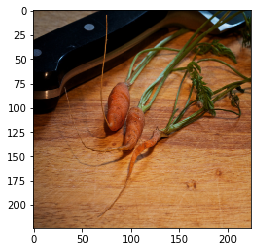

Predicted caption: 
 a fruit stall with bananas at a marketplace eeee



In [132]:
x = 306454
y = image_list_train.tolist().index(x)
pred = generate_caption("../input/train-2017-10k/newtrain10/newTrain10/000000306454.jpg")

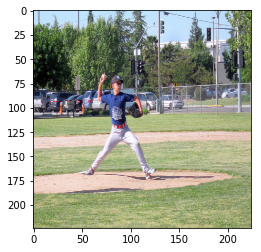

Predicted caption: 
 a girl on her cell phone holding a controller giving the finger eeee



In [138]:
x = 555271
y = image_list_train.tolist().index(x)
pred = generate_caption("../input/train-2017-10k/newtrain10/newTrain10/000000555271.jpg")

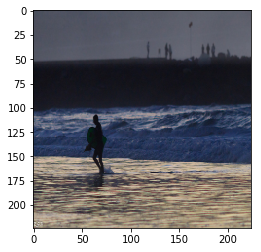

Predicted caption: 
 a black and white photo of someone on a skate board eeee



In [131]:
x = 325243
y = image_list_train.tolist().index(x)
pred = generate_caption("../input/train-2017-10k/newtrain10/newTrain10/000000325243.jpg")

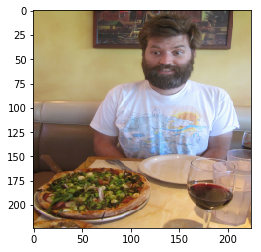

Predicted caption: 
 a shops table filled with apples oranges and other fruits eeee



In [133]:
x = 284703
y = image_list_train.tolist().index(x)
pred = generate_caption("../input/train-2017-10k/newtrain10/newTrain10/000000284703.jpg")

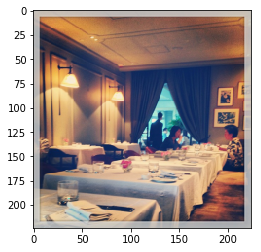

Predicted caption: 
 a man in a vest standing in a bathroom eeee



In [135]:
x = 324682
y = image_list_train.tolist().index(x)
pred = generate_caption("../input/train-2017-10k/newtrain10/newTrain10/000000324682.jpg")